# Project 1
- Course: ST 590-601
- Authors: Richard Xiao, Derek Frick

## Purpose

The purpose of this report is to demonstrate our ability to program in python by inputing data from a file source, processing that input into a useable format, creating analytical models for inference, and validating those models as per the specifications outlined in the project documentation.

First, let's import all the packages we'll need to run the code used in this project.

In [1]:
import pandas as pd
import numpy as np
import functools

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn import linear_model
from sklearn.metrics import mean_squared_error

## Data Processing

We'll create some tools to process our data for analysis.

First, let's do the first one manually. Afterwards, we'll convert these steps into callable functions. Because we'll eventually be converting these to functions, we'll try to use variables where appropriate instead of 'hardcoding' any data.

In [2]:
#provide the filepath of the csv file for importing
f = 'https://www4.stat.ncsu.edu/~online/datasets/EDU01a.csv'

#read in the data - note the delimiter is the defaul comma for csv and header rows are in the default position
df = pd.read_csv(f)

Next, we'll use the the `.loc[]` method to only include columns **Area_name**, **STCOU**, and any column that ends in "D". Note, the column formats need no case adjustment such as `.upper()`.

In [3]:
#use the .loc[] method and 
df = df.loc[:,df.columns.isin([i for i in df.columns if (i in ['Area_name','STCOU']) or (i.endswith('D'))])]

Next, we need to reshape the dataframe so that the datavalues are stacked by the index variables **Area_name** and **STCOU** using the `pd.melt()` function.

In [4]:
df = df.melt(id_vars = ['Area_name','STCOU'], value_name = 'enrollment')

Next, we need to parse the new column named **variable** by splitting the string where the first 7 characters represent the type of data collected and the year of the survey are represented by the following two characters. Create a new column, **year** (in a format YYYY), and a column **measurement** that contains the data value.

We'll do this using a loop.

In [5]:
#initialize the lists to contain the two new sets of data to add to the dataframe
msmt = []
year = []

#create a loop to iterate through each item in the variable column of the dataframe
for i in df.variable:
    
    #splice the string to find the year and convert to integer
    yy = float(i[7:9]) 
    
    #use if statements to fix the year into YYYY format
    if yy <= 23:
        yyyy = 2000 + yy
    else:
        yyyy = 1900 + yy
        
    #append a spliced string containing the measurement information and the converted integer yield
    msmt.append(i[0:7])
    year.append(yyyy)

#add the new data to the dataframe
df['year'] = year
df['measurement'] = msmt


#remove the old column, that is no longer needed
df = df.drop(columns='variable')

Next, we'll subset our dataframe into two dataframes:
- One dataframe will contain only county level data
- One dataframe will contain all non-county level data

To do this, we'll use a mask (indexing vector) by using the `.apply()` method and a `lambda` function. This method will create a boolean series that can then be used as a *mask* to subset the dataset for any location where the format of **Area_name** is consistent with a "County, ST" format. 

Afterwards, we'll apply `np.logical_not()` to create a *mask* of the alternate boolean to subset the dataset again to create the dataframe where the format of **Area_name** is not consistent with a "County, ST" format.


In [6]:
#create a boolean list (mask) using the apply method for where the Area_name variable conains a "," in the expected position of  County, ST
mask =  df.apply(lambda row: row['Area_name'].find(',') == len(row['Area_name'])-4,axis=1)

#create a copy if the masked dataframe consistent with county level data
df_county = df[mask].copy()

#create a copy of the masked datafrome not consistent with county level data, using np.logical_not().
df_nonCounty = df[np.logical_not(mask)].copy()

Next, we'll add a column to the county level dataframe that specifies the state of the county in a new column **state**.

In [7]:
#use the apply method and lambda function again to assign values to a new column in the dataframe
df_county['state'] = df.apply(lambda row: row['Area_name'][-2:],axis=1)

Next, we'll want to create a new column named **division** in the non-county dataframe, that contains the division to which each state belongs. To do this we'll create a function that uses `if/elif` logic based on **Area_name** and use `np.vectorize()` to broadcast the function to a full vector to create the column.

In [8]:
#define a function that takes the Area_name as a variable
def division_finder(Area_name):
    
    #create a dictionary where the keys are the divisions, and the values are a list of states within those divisions (reference the census information)
    divisions = {'ERROR':['UNITED STATES'],
                 'Division 1':['CONNECTICUT','MAINE','MASSACHUSETTS','NEW HAMPSHIRE','RHODE ISLAND','VERMONT'],
                 'Division 2':['NEW JERSEY','NEW YORK','PENNSYLVANIA'],
                 'Division 3':['ILLINOIS','INDIANA','MICHIGAN','OHIO','WISCONSIN'],
                 'Division 4':['IOWA','KANSAS','MINNESOTA','MISSOURI','NEBRASKA','NORTH DAKOTA','SOUTH DAKOTA'],
                 'Division 5':['DELAWARE','FLORIDA','GEORGIA','MARYLAND','NORTH CAROLINA','SOUTH CAROLINA','VIRGINIA','WASHINGTON, D.C.','DISTRICT OF COLUMBIA','WEST VIRGINIA'],
                 'Division 6':['ALABAMA','KENTUCKY','MISSISSIPPI','TENNESSEE'],
                 'Division 7':['ARKANSAS','LOUISIANA','OKLAHOMA','TEXAS'],
                 'Division 8':['ARIZONA','COLORADO','IDAHO','MONTANA','NEVADA','NEW MEXICO','UTAH','WYOMING'],
                 'Division 9':['ALASKA','CALIFORNIA','HAWAII','OREGON','WASHINGTON']
                }
    
    #iterate through the dictionary until the Area_name is found. Force upper case of search item
    for k,v in divisions.items():
        if Area_name.upper() in v:
            div = k
            break
        
        #give an out in case there is an Area_name that doesn't fit the dictionary values
        else:
            div = 'NOT IN LIST'
            
    return div

#define a vectorized object for broadcasting
divisioner = np.vectorize(division_finder)

#create a new column with division information by using the vectorized object with Area_name passed to it
df_nonCounty['division'] = divisioner(df_nonCounty.Area_name)

Just a quick check that all states / locations in the file were found in the dictionary

In [9]:
len(df_nonCounty[df_nonCounty.division == 'NOT IN LIST']) == 0

True

In [10]:
df,df_county,df_nonCounty

(            Area_name  STCOU  enrollment    year measurement
 0       UNITED STATES      0    40024299  1987.0     EDU0101
 1             ALABAMA   1000      733735  1987.0     EDU0101
 2         Autauga, AL   1001        6829  1987.0     EDU0101
 3         Baldwin, AL   1003       16417  1987.0     EDU0101
 4         Barbour, AL   1005        5071  1987.0     EDU0101
 ...               ...    ...         ...     ...         ...
 31975  Sweetwater, WY  56037        9599  1996.0     EDU0101
 31976       Teton, WY  56039        2226  1996.0     EDU0101
 31977       Uinta, WY  56041        5750  1996.0     EDU0101
 31978    Washakie, WY  56043        1900  1996.0     EDU0101
 31979      Weston, WY  56045        1479  1996.0     EDU0101
 
 [31980 rows x 5 columns],
             Area_name  STCOU  enrollment    year measurement state
 2         Autauga, AL   1001        6829  1987.0     EDU0101    AL
 3         Baldwin, AL   1003       16417  1987.0     EDU0101    AL
 4         Barbour, AL 

## User Defined Functions

Now that we've done the data process manually, let's create a series of functions to combine into a single **wrapper** function to complete data processing in one step.

In [11]:
def p12(f, value_name = 'default'):
    #read in the data - note the delimiter is the defaul comma for csv and header rows are in the default position
    df = pd.read_csv(f)
    
    #use the .loc[] method and 
    df = df.loc[:,df.columns.isin([i for i in df.columns if (i in ['Area_name','STCOU']) or (i.endswith('D'))])]
    
    df = df.melt(id_vars = ['Area_name','STCOU'], value_name = value_name)
    
    return df

def p3(df):
    #initialize the lists to contain the two new sets of data to add to the dataframe
    msmt = []
    year = []

    #create a loop to iterate through each item in the variable column of the dataframe
    for i in df.variable:
    
        #splice the string to find the year and convert to integer
        yy = float(i[7:9]) 
    
        #use if statements to fix the year into YYYY format
        if yy <= 23:
            yyyy = 2000 + yy
        else:
            yyyy = 1900 + yy
        
        #append a spliced string containing the measurement information and the converted integer yield
        msmt.append(i[0:7])
        year.append(yyyy)

    #add the new data to the dataframe
    df['year'] = year
    df['measurement'] = msmt


    #remove the old column, that is no longer needed
    df = df.drop(columns='variable')
    
    return df

def p5(df):
    #use the apply method and lambda function again to assign values to a new column in the dataframe
    df['state'] = df.apply(lambda row: row['Area_name'][-2:],axis=1)
    
    return df

def p6(df):
    #define a vectorized object for broadcasting
    divisioner = np.vectorize(division_finder)

    #create a new column with division information by using the vectorized object with Area_name passed to it
    df['division'] = divisioner(df.Area_name)
    
    return df
    
def p4(df):
    #create a boolean list (mask) using the apply method for where the Area_name variable conains a "," in the expected position of  County, ST
    mask =  df.apply(lambda row: row['Area_name'].find(',') == len(row['Area_name'])-4,axis=1)

    #create a copy if the masked dataframe consistent with county level data
    df_county = df[mask].copy()

    #create a copy of the masked datafrome not consistent with county level data, using np.logical_not().
    df_nonCounty = df[np.logical_not(mask)].copy()
    
    return [p5(df_county), p6(df_nonCounty)]

def wrapper(filepath, value_name = 'default'):
    return p4(p3(p12(filepath,value_name)))

Now let's test the above wrapper function by calling it to read in and parse the two data files provided in the project specification.
Note, we'll use the variable fi for file paths were i is an index of file paths (i.e. f,f2,f3,f4, etc.).
The outputs of the wrapper should be two dataframes in a list that match the expectations in the project specification.

Let's pass the outputs of these processed datas to two new variables, ds1 and ds2.

In [12]:
#the original filepath was saved as 'f'. Let's use 'f2' to specify the new file path to test
f2 = 'https://www4.stat.ncsu.edu/~online/datasets/EDU01b.csv'

#for consistency in naming, let's use a variable, value_name to change the data column used in wrapper
value_name = 'enrollment'

ds1 = wrapper(f,value_name = value_name)
ds2 = wrapper(f2,value_name = value_name)

Next, we'll do some more data cleaning - we'll create a new function that takes unlimited arguements to stack and clean outputs from the `wrapper()` function by use of `map()`, `lambda` functions, `reduce()`, `functools` and `pd.concat()`.

In [13]:
#define the function to take on an unlimited number of optional arguments
def joiner(*datasets):
    #create an iterable object (map) based on the datasets passed into the function. note that the inputs will always have the county data in the first element based on the wrapper function
    a = map(lambda x: x[0], datasets)
    #use reduce to stack those objects in the iterable map sequentially 
    b = functools.reduce(lambda x, y: pd.concat([x,y]), a)
    
    #do the same as above, but this time for the non county data in the second element of each argument
    c = map(lambda x: x[1], datasets)
    #use reduce to stack those objects in the iterable map sequentially 
    d = functools.reduce(lambda x, y: pd.concat([x,y]), c)    
    
    #return a list of the stacked datasets, just like wrapper does where the first element is county level data, and the second the non county data
    return [b,d]

Next, lets check to make sure it's working well all together.

Let's pass the two file names we have already generated as **ds1** and **ds2** into the function we made above and compare the output to the example provided in the project specification.

In [14]:
joiner(ds1,ds2)

[            Area_name  STCOU  enrollment    year measurement state
 2         Autauga, AL   1001        6829  1987.0     EDU0101    AL
 3         Baldwin, AL   1003       16417  1987.0     EDU0101    AL
 4         Barbour, AL   1005        5071  1987.0     EDU0101    AL
 5            Bibb, AL   1007        3557  1987.0     EDU0101    AL
 6          Blount, AL   1009        7319  1987.0     EDU0101    AL
 ...               ...    ...         ...     ...         ...   ...
 31975  Sweetwater, WY  56037        6964  2006.0     EDU0152    WY
 31976       Teton, WY  56039        2264  2006.0     EDU0152    WY
 31977       Uinta, WY  56041        4298  2006.0     EDU0152    WY
 31978    Washakie, WY  56043        1410  2006.0     EDU0152    WY
 31979      Weston, WY  56045        1076  2006.0     EDU0152    WY
 
 [62900 rows x 6 columns],
            Area_name  STCOU  enrollment    year measurement    division
 0      UNITED STATES      0    40024299  1987.0     EDU0101       ERROR
 1       

As shown above, the outputs match the example output in the specification document. It works. **Sweet**

Let's check it again with more data.

Let's read in the four provided datasets in the specification and compare to the example output.

In [15]:
#specify file paths
files = ['https://www4.stat.ncsu.edu/~online/datasets/PST01a.csv',
         'https://www4.stat.ncsu.edu/~online/datasets/PST01a.csv',
         'https://www4.stat.ncsu.edu/~online/datasets/PST01c.csv',
         'https://www4.stat.ncsu.edu/~online/datasets/PST01d.csv'
        ]

#create outputs of the wrapper function based on the filepaths
ds3 = wrapper(files[0])
ds4 = wrapper(files[1])
ds5 = wrapper(files[2])
ds6 = wrapper(files[3])

#pass the outputs of the wrapper to the joiner -- note the specification has the default column name, so here we won't pass an optional column name to confirm it works / matches the example
joiner(ds3,ds4,ds5,ds6)

[            Area_name  STCOU  default    year measurement state
 2         Autauga, AL   1001    25508  1971.0     PST0151    AL
 3         Baldwin, AL   1003    60141  1971.0     PST0151    AL
 4         Barbour, AL   1005    23092  1971.0     PST0151    AL
 5            Bibb, AL   1007    13919  1971.0     PST0151    AL
 6          Blount, AL   1009    27817  1971.0     PST0151    AL
 ...               ...    ...      ...     ...         ...   ...
 31975  Sweetwater, WY  56037    41226  2009.0     PST0452    WY
 31976       Teton, WY  56039    20710  2009.0     PST0452    WY
 31977       Uinta, WY  56041    20927  2009.0     PST0452    WY
 31978    Washakie, WY  56043     7911  2009.0     PST0452    WY
 31979      Weston, WY  56045     7009  2009.0     PST0452    WY
 
 [125800 rows x 6 columns],
            Area_name  STCOU    default    year measurement    division
 0      UNITED STATES      0  206827028  1971.0     PST0151       ERROR
 1            ALABAMA   1000    3497452  1971.

The output above matches the example in the project specification. It works! **Sweet**

## Cross-Validation

## Subset the data
From the datasets above, create a non county level dataset. We'll use our defined functions and pull the non county data element from the returned list.
Next we'll use the `.loc` method to subset the data again to only include **year, division, and enrollment** variables and exclude divisions that result in **ERROR**.

In [16]:
enrollment = joiner(ds1,ds2)
non_county_enrollment = enrollment[1]
non_county_enrollment = non_county_enrollment.loc[
    non_county_enrollment["division"] != "ERROR", 
    [value_name, "year","division"]
    ]

Next, let's create a simple linear regression (SLR) and multiple linear regression (MLR) model.
Our predictors will be **year and dvisions** and our reponse will be **enrollment**.

To fit the MLR, we will need to create dummy variables to create binary values for each categorical level.

In [17]:
non_county_enrollment_dummies=pd.get_dummies(data = non_county_enrollment['division'])
non_county_enrollment_dummies=non_county_enrollment_dummies.drop(columns = 'Division 9')
new_non_county_enrollment=pd.concat([non_county_enrollment,non_county_enrollment_dummies],axis = 1)

Before fitting the regression, we wanted to exploratory data analysis on the non county enrollment data set. We decided to create scatterplots subdivided by region. There seems to be a widespread difference among our divisions. It seems that the enrollment values are increasing over time. This appears that the data may need some standardizing.

division
Division 1    AxesSubplot(0.125,0.11;0.775x0.77)
Division 2    AxesSubplot(0.125,0.11;0.775x0.77)
Division 3    AxesSubplot(0.125,0.11;0.775x0.77)
Division 4    AxesSubplot(0.125,0.11;0.775x0.77)
Division 5    AxesSubplot(0.125,0.11;0.775x0.77)
Division 6    AxesSubplot(0.125,0.11;0.775x0.77)
Division 7    AxesSubplot(0.125,0.11;0.775x0.77)
Division 8    AxesSubplot(0.125,0.11;0.775x0.77)
Division 9    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

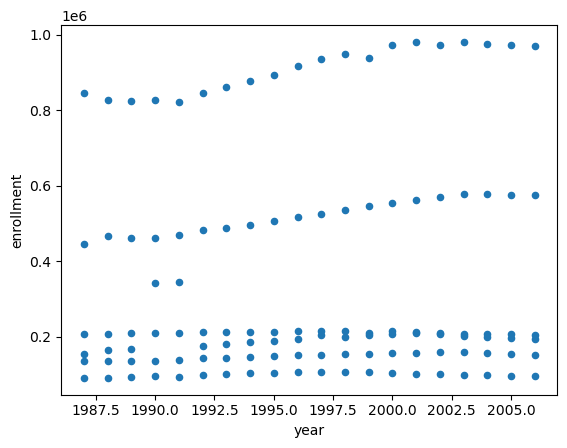

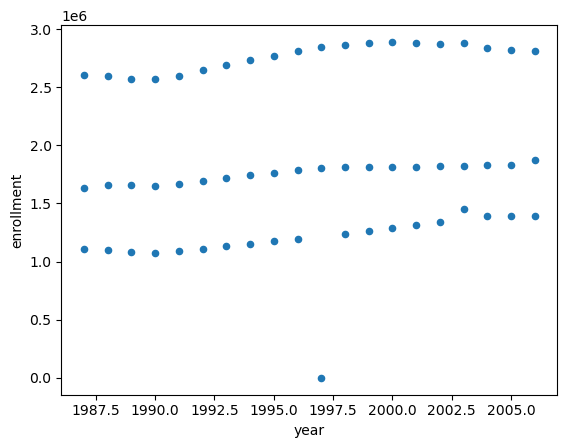

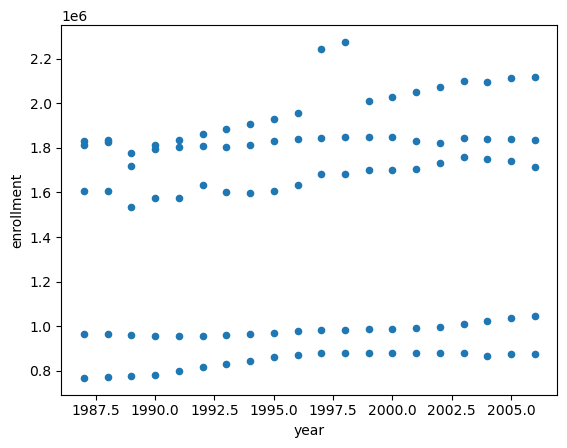

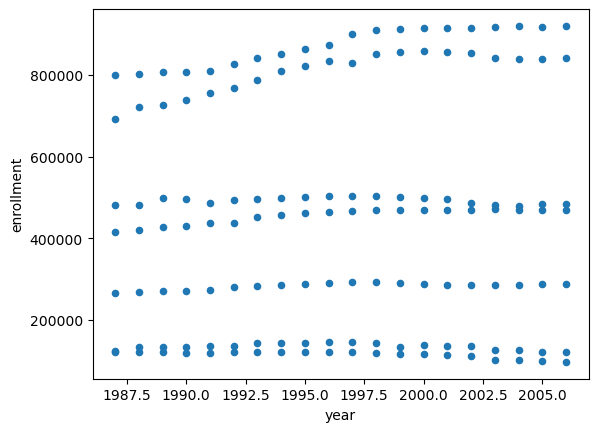

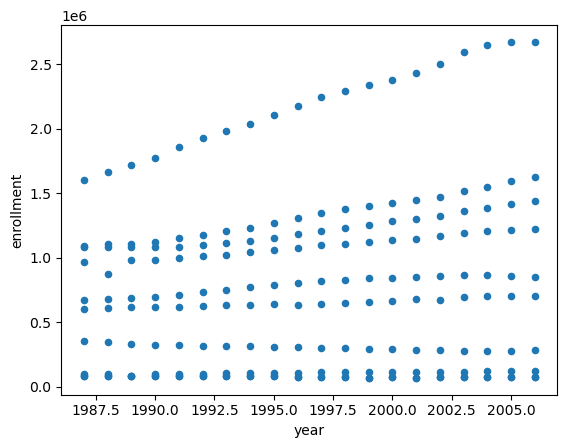

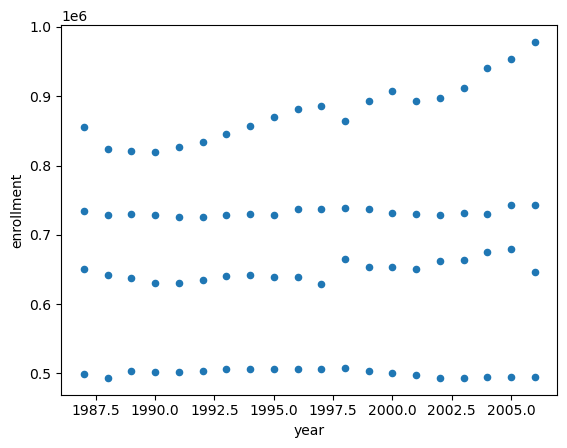

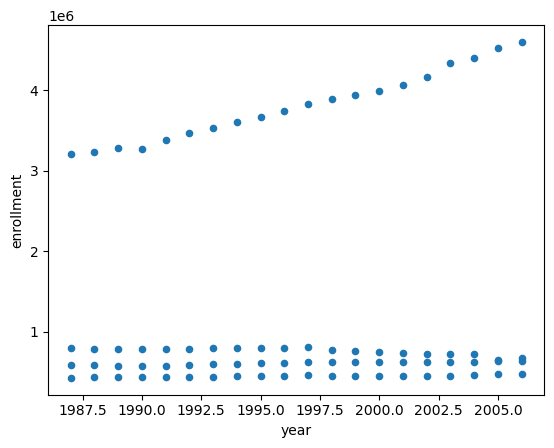

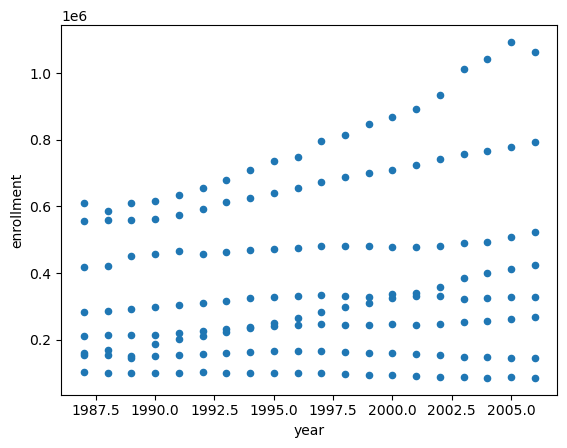

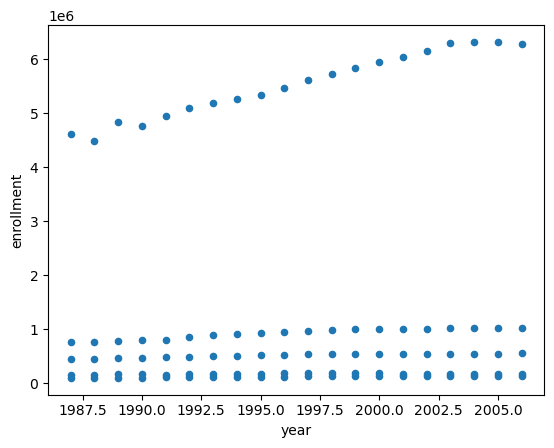

In [44]:
new_non_county_enrollment.groupby('division').plot.scatter(y = 'enrollment', x = 'year')

Next, we'll use `sklean` to fit linear regressions on the dataset split into two new objects:
**X** = all predictor variables ('year' and dummy divisions)
**y** = all enrollment data (with year included for further subsetting and CV

In [18]:
X = new_non_county_enrollment.drop(columns = ['enrollment','division'])
y = new_non_county_enrollment[['enrollment','year']]

reg = linear_model.LinearRegression() 
reg.fit(X = X['year'].values.reshape(-1,1), y = y['enrollment'].values)

LinearRegression()

The above fits were successful.

## Cross-Validation

Next, we'll create a function to subset our dataset based on a starting year.  Data up to and prior to that year will train the linear model. Data post that year, we'll use a test to calculate the total MSE and compare the model's performance.

To accomplish this, we'll fit both the SLR and MLR in one function and return the output into two elements of a list.

In [27]:
#the mse function will take in two datasets and last year arguement to fit the model and calculate the MSE of the next prior year.
def mse(X, y, last_year):  
    
        #Create the training and test datasets
        y_train = y.loc[y['year']<=last_year]
        y_test = y.loc[y['year'] == last_year+1]
        x_train = X.loc[y['year']<=last_year]
        x_test = X.loc[y['year'] == last_year+1]
        
        #SLR
        slr_reg = linear_model.LinearRegression() 
        slr_reg.fit(X = x_train['year'].values.reshape(-1,1), y = y_train['enrollment'].values)
        slr_mse = mean_squared_error(y_test['enrollment'].values,slr_reg.predict(x_test['year'].values.reshape(-1,1)))
        
        #MLR
        mlr_reg = linear_model.LinearRegression()
        mlr_reg.fit(X = x_train, y = y_train['enrollment'])
        mlr_mse = mean_squared_error(y_test['enrollment'],mlr_reg.predict(x_test))
        return [slr_mse,mlr_mse]

#the CV function will take in the starting year and 
def CV(X, y, first_year):
    #check that first year is past 1989
    if first_year < 1989:
        raise ValueError('first year must be past 1989')

    
    #intialize mse to zero
    sum_mse = [0,0]
    
    #find the upper bound of the loop
    final_year = min(max(X['year']),max(y['year']))
    
    #iterate over the datasets to find the total mse
    for year in range(int(first_year),int(final_year)):
        temp_mse = mse(X,y,year)
        sum_mse[0] += temp_mse[0]
        sum_mse[1] += temp_mse[1]
        
    return sum_mse

In [48]:
model_compare = []

first_year = 1989
last_year = 2006

for yr in range(first_year,last_year):
    temp_mse = CV(X,y,yr)
    if temp_mse[0]<temp_mse[1]:
        best_fit = 'SLR Wins'
    else:
        best_fit = 'MLR Wins'
    model_compare.append([yr,CV(X,y,yr),best_fit])


In [46]:
model_compare

[[1989, [17290390796689.781, 13014125525966.371], 'MLR Wins'],
 [1990, [16563485826919.633, 12492335650294.537], 'MLR Wins'],
 [1991, [15790755764147.889, 11931219052155.922], 'MLR Wins'],
 [1992, [14971931057575.545, 11336665227837.506], 'MLR Wins'],
 [1993, [14126599570851.64, 10720299372439.45], 'MLR Wins'],
 [1994, [13255100893241.729, 10082732252573.352], 'MLR Wins'],
 [1995, [12355413911243.746, 9422317604901.955], 'MLR Wins'],
 [1996, [11415931370089.16, 8729567180948.595], 'MLR Wins'],
 [1997, [10406577949912.275, 7932972979501.816], 'MLR Wins'],
 [1998, [9374270729514.95, 7165275473496.259], 'MLR Wins'],
 [1999, [8321072479884.709, 6375164230987.679], 'MLR Wins'],
 [2000, [7236745068463.213, 5556970182658.882], 'MLR Wins'],
 [2001, [6119864007407.295, 4709428597469.638], 'MLR Wins'],
 [2002, [4964806485634.869, 3828690724065.042], 'MLR Wins'],
 [2003, [3744245916232.832, 2893905878364.917], 'MLR Wins'],
 [2004, [2509363646164.543, 1941644787983.414], 'MLR Wins'],
 [2005, [1257

The MLR model consistently has less **MSE** than the SLR of the test dataset regardless of the `first_year` starting position, likely because we're using more parameters to describe our dataset. So in general, MLR appears to predict more accurately than SLR. Additionally, the higher the starting year in the intial model, the better the MSE.